In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import NormalDist
import glob
from collections import defaultdict

from scipy.stats import ttest_ind, f_oneway

In [2]:

label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']
label_df.head(4)
dx_df = pd.read_csv("../../Data/Pat_Epilepsy_Subtype.csv")

In [3]:
TLE_IDS = dx_df[dx_df["Pure mTLE"] ==1].PatID.values
NON_TLE_IDS = dx_df[dx_df["Pure mTLE"] !=1].PatID.values

In [4]:
def split_bipole(bip_df: pd.DataFrame):
    """splits the bipole column of a bipole df
    duplicates rows

    """
    assert 'bipole' in bip_df.columns, "Need bipole column!"

    contact1 = bip_df.bipole.apply(lambda x: x.split("-")[0].strip(" "))
    contact2 = bip_df.bipole.apply(lambda x: x.split("-")[1].strip(" "))
# python resultAggregator.py -s 'Epat38' -p '/mnt/ernie_main/Ghassan/ephys/data/Epat38'
    df2 = bip_df.copy(deep=True)

    bip_df['contact'] = contact1
    df2['contact'] = contact2


    return pd.concat([bip_df,df2])

def map_label(label):
    label = int(label)
    match label:
        case 0:
            return "NIZ"
        case 1:
            return 'SOZ'
        case 2:
            return 'PZ'
        case 3:
            return 'IZ'
        
def merge_label(subj_df: pd.DataFrame, label_df: pd.DataFrame, leftcol: str, rightcol: str ) -> pd.DataFrame:
    """Merges contact label into the subj_df for both stim and response regions

    Args:
        subj_df (pd.DataFrame): dataframe with SPES data, could be CRP, raw SPES, etc
        as long as each row has an entry for a bipole (or monopolar) contact to merge on. 
        ASSUMES 'subj' is a column for sanity checks.
       
        label_df (pd.DataFrame): labels designating 'SOZ', 'NIZ', 'PZ', should be originating 
        from the 'all_pats_bipole.csv', may contain more than one subject, but ASSUMES 'subj' is a column.

        leftcol (str): column of subject bipoles, could be stim, or resp, will be renamed
        'leftcol_label'

       merge_labeleturns:
        pd.DataFrame: subj df with columns for labels
    """
    assert 'subj' in subj_df.columns, "Need a 'subj' column! in subj_df"
    assert 'subj' in label_df.columns, "Needa 'subj' column in label_df"
    assert 'label' in label_df.columns, "Need a label to merge into subj_df, check label_df!"
    subj = subj_df.subj.values[0]
    assert subj in set(label_df.subj.values) ,f"Subject: {subj} missing from label df!"
    assert len(set(subj_df.subj)) == 1, 'Can only merge one subject at a time!'
    og_rows = subj_df.shape[0]
    label_df = label_df[label_df.subj == subj]
    reg_map = defaultdict(lambda: "UNLABELED")
    reg_map.update({reg:label for reg,label in label_df[[rightcol,'label']].values})
    subj_df[ f'{leftcol}_label'] = subj_df[leftcol].apply(lambda x: reg_map[x])  # subj_df = subj_df.merge(label_df[[rightcol, 'label']], left_on=leftcol, right_on=rightcol)
    assert og_rows >= subj_df.shape[0], f"For {subj}\n\t\texpected at most {og_rows}, after merge: {subj_df.shape[0]} rows detected"
    return subj_df



label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

relabel = defaultdict(lambda:"NIZ")
relabel['SOZ'] = 'SOZ' 
label_df['label'] = [relabel[x] for x in label_df.label.values]



In [5]:
label_df

,subj,bipole,label,contact
0,Epat31,AH3-AH4,SOZ,AH3
1,Epat31,AH4-AH5,SOZ,AH4
2,Epat31,AH5-AH6,SOZ,AH5
3,Epat31,PH1-PH2,SOZ,PH1
4,Epat31,PH2-PH3,SOZ,PH2
...,...,...,...,...
7048,Spat55,LCM6-LCM7,NIZ,LCM7
7049,Spat55,LCM8-LCM9,NIZ,LCM9
7050,Spat55,LCM9-LCM10,NIZ,LCM10
7051,Spat55,LCM10-LCM11,NIZ,LCM11


In [6]:
tst = '/mnt/ernie_main/Ghassan/ephys/data/Epat26/Epat26_stim.csv'
tst_df = pd.read_csv(tst)
tmp = merge_label(tst_df,label_df, 'resp_reg', 'bipole')


## Aggregating Results File
This stage reads through the results data on ernie and loads all stim csvs into one dataframe. 
This portion also labels the stim location as SOZ, NIZ, PZ, EZ, using label_df from above. For any regions unlabelled, the stim data is thrown out. 

In [7]:
RES_FILES = glob.glob('/mnt/ernie_main/Ghassan/ephys/data/*pat*/*pat*_stim.csv')
print(len(RES_FILES))
RES_FILES.remove( '/mnt/ernie_main/Ghassan/ephys/data/Spat56/Spat56_stim.csv')
#no label for file currently
print(len(RES_FILES))


26
25


In [8]:

import pdb
def agg_subject_results(result_files: list[str], label_df: pd.DataFrame) -> pd.DataFrame:
    dfs = []
    expected_rows = 0
    for f in result_files:
        res_df = pd.read_csv(f)
        subj = res_df.subj.values[0]
        res_df.resp_reg = res_df.resp_reg.apply(lambda x: x.replace(" ", ""))
        expected_rows += res_df.shape[0]
        tmp = merge_label(res_df,label_df, 'resp_reg', 'bipole')
        merge_df = merge_label(tmp, label_df, 'stim_reg', 'bipole')        
        dfs.append(merge_df)
    dfs = pd.concat(dfs)
    dfs = dfs[dfs.stim_reg_label != "UNLABELED"]
    dfs = dfs[dfs.resp_reg_label != "UNLABELED"]
    assert expected_rows >= dfs.shape[0], f"Expected at most {expected_rows}, got {dfs.shape[0]}\n\t\t diff: {expected_rows - dfs.shape[0]}"
    print(f"{len(set(dfs.subj))} subjects, total of {dfs.shape[0]} trials, dropped: {expected_rows - dfs.shape[0]}")
    return dfs

res_df = agg_subject_results(RES_FILES, label_df.drop_duplicates())


24 subjects, total of 1517551 trials, dropped: 612058


### Loading Euclidean Distances

The all_pats_euclidean contains a truly massive csv of all bipole pairs and their calculated euclidean distance. This will become important in our analysis for 2 reasons:
1. In the ISH paper, we consider that contacts within 20mm of the stimulation electrode are overriden with stim artifact, thus we need to know to discount them.
2. We can use distance from stimulation source to understand the persistence of certain effects. For example, we expect that electrodes closer to the stimulation site will likely have higher explained variance (conduction effect + stim artifact that remains). So plotting explained variance over distance should help to disentangle some of these confounds

In [9]:
dist_df = pd.read_csv('/mnt/ernie_main/000_Data/SEEG/SEEG_EyesClosed_RestingState/labels/all_pats_euc_dist_list.csv',header=None)
dist_df.columns = ['subj', 'bipole1', 'bipole2','dist']
subj_set = set(res_df.subj)
dist_df = dist_df[dist_df.subj.isin(subj_set)]

In [10]:
dist_df

,subj,bipole1,bipole2,dist
220081,Epat26,LAC1-LAC2,LAC1-LAC2,0.0000
220082,Epat26,LAC1-LAC2,LP1-LP2,65.8629
220083,Epat26,LAC1-LAC2,LP2-LP3,65.3933
220084,Epat26,LAC1-LAC2,LTP1-LTP2,66.3953
220085,Epat26,LAC1-LAC2,LTP2-LTP3,66.1579
...,...,...,...,...
667058,Spat55,RAH12-RAH13,RAH8-RAH9,14.1735
667059,Spat55,RAH12-RAH13,RAH9-RAH10,10.5745
667060,Spat55,RAH12-RAH13,RAH10-RAH11,7.0017
667061,Spat55,RAH12-RAH13,RAH11-RAH12,3.5366


In [11]:
## Create a dictionary which takes in a subject and 2 contacts and maps those values 
## to a distance

dist_map = defaultdict(lambda: -1)
dist_map.update({f'{subj}-{bip1}-{bip2}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})
dist_map.update({f'{subj}-{bip2}-{bip1}':d for subj,bip1,bip2,d in dist_df[['subj','bipole1','bipole2','dist']].values})

tst_df = res_df.copy(deep=True)
tst_df['dist'] = [dist_map[f"{subj}-{stim_reg}-{resp_reg}"] for subj,stim_reg,resp_reg in tst_df[['subj','stim_reg','resp_reg']].values]

In [12]:
resdist_df = tst_df

In [13]:
resdist_df

,alphas,TR,resp_reg,alpha_prime,explained_variance,t_peak_0,stim_reg,ma,subj,resp_reg_label,stim_reg_label,Unnamed: 0,dist
0,-85.664122,0.773438,LA3-LA4,-0.216324,0.126290,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
1,3.287837,0.773438,LA3-LA4,0.008303,0.000291,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
2,-18.637251,0.773438,LA3-LA4,-0.047064,0.008326,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
3,98.596516,0.773438,LA3-LA4,0.248981,0.187390,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
4,-82.030970,0.773438,LA3-LA4,-0.207149,0.137844,0.023438,LAC3-LAC4,5mA,Epat26,NIZ,NIZ,NaN,73.4286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94095,-129.277484,0.078125,RPH5-RPH6,-3.231937,0.936492,0.013672,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94096,36.182861,0.078125,RPH5-RPH6,0.904572,0.285267,0.013672,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94097,13.503523,0.078125,RPH5-RPH6,0.337588,0.051016,0.013672,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642
94098,-160.262739,0.078125,RPH5-RPH6,-4.006568,0.980377,0.013672,LAH11-LAH12,1mA,Spat55,NIZ,NIZ,NaN,96.2642


##### Filtering Down on the SPES Dataset
2 criteria here: 
1. Distance from the stim electrode - ISH used 20mm to ensure no stim artifact, I used 5 mm in my initial pass to be most permissive
2. Trial parameters : Only using 3mA trials. Most subcortical structures are not probed above 3mA for safety concerns. So this is the highest amperage we can assess most structures at. 

In [14]:
#Filtera conditions
resdist_df = resdist_df[resdist_df.dist > 20] #20mm is in line with ISH
resdist_df = resdist_df[resdist_df.ma == '3mA']
#resdist_df = resdist_df[resdist_df.TR > 20]

# Group Analysis
This is where the magic (should) be happening. Stim responses are grouped at level of stim region and response region then their group mean is calculated. Previously, each row in this dataframe represented the parameterization of each pulse. This first aggregation groups within trials 

In [15]:
cols = ['subj','stim_reg','resp_reg','alphas','alpha_prime','TR', 't_peak_0','dist', "resp_reg_label","stim_reg_label"]
group = resdist_df[cols].groupby(['subj','resp_reg', 'stim_reg',"resp_reg_label","stim_reg_label"])
group_df = group.mean()

In [16]:
group_df


alphas  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label               
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             -27.702660   
                 LAH1-LAH2   NIZ            SOZ              73.581857   
                 LAH7-LAH8   NIZ            NIZ              10.854676   
                 LAH9-LAH10  NIZ            NIZ            -122.257542   
                 LAM13-LAM14 NIZ            NIZ              98.254344   
...                                                                ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             -43.724903   
                 LPH8-LPH9   NIZ            NIZ             -39.994653   
                 LPP12-LPP13 NIZ            NIZ              86.526701   
                 RAH10-RAH11 NIZ            NIZ            -116.357326   
                 RPH13-RPH14 NIZ            NIZ              -6.250312   

                                                            alpha_prime  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label                
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ               -2.770266   
                 LAH1-LAH2   NIZ            SOZ                0.518182   
                 LAH7-LAH8   NIZ            NIZ                0.201013   
                 LAH9-LAH10  NIZ            NIZ               -0.251559   
                 LAM13-LAM14 NIZ            NIZ                0.226392   
...                                                                 ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ               -0.130913   
                 LPH8-LPH9   NIZ            NIZ               -2.221925   
                 LPP12-LPP13 NIZ            NIZ                0.313503   
                 RAH10-RAH11 NIZ            NIZ               -0.559410   
                 RPH13-RPH14 NIZ            NIZ               -0.625031   

                                                                  TR  \
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label             
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             0.019531   
                 LAH1-LAH2   NIZ            SOZ             0.277344   
                 LAH7-LAH8   NIZ            NIZ             0.105469   
                 LAH9-LAH10  NIZ            NIZ             0.949219   
                 LAM13-LAM14 NIZ            NIZ             0.847656   
...                                                              ...   
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             0.652344   
                 LPH8-LPH9   NIZ            NIZ             0.035156   
                 LPP12-LPP13 NIZ            NIZ             0.539062   
                 RAH10-RAH11 NIZ            NIZ             0.406250   
                 RPH13-RPH14 NIZ            NIZ             0.019531   

                                                            t_peak_0     dist  
subj   resp_reg  stim_reg    resp_reg_label stim_reg_label                     
Epat26 LA1-LA2   LAC9-LAC10  NIZ            NIZ             0.009766  79.6650  
                 LAH1-LAH2   NIZ            SOZ             0.009766  47.4889  
                 LAH7-LAH8   NIZ            NIZ             0.001953  40.6558  
                 LAH9-LAH10  NIZ            NIZ             0.023438  40.3105  
                 LAM13-LAM14 NIZ            NIZ             0.001953  52.8940  
...                                                              ...      ...  
Spat55 RPH5-RPH6 LPH10-LPH11 NIZ            NIZ             0.001953  88.8157  
                 LPH8-LPH9   NIZ            NIZ             0.015625  82.1453  
                 LPP12-LPP13 NIZ            NIZ             0.017578  80.8635  
                 RAH10-RAH11 NIZ            NIZ             0.021484  24.2677  
                 RPH13-RPH14 NIZ            NIZ             0.003906  28.4858  

[43476 rows x 5 columns]

In [17]:
resdist_df['stim_rel'] = [f"{a}-{b}" for a,b in resdist_df[['resp_reg_label','stim_reg_label']].values]
resdist_df['stim_sesh'] = [f"{stim}-{resp}" for stim, resp in resdist_df[['stim_reg','resp_reg']].values ]
stim_rel_map = {f"{subj}-{stim_sesh}":stim_rel for subj,stim_sesh,stim_rel in resdist_df[['subj','stim_sesh','stim_rel']].values}

In [18]:

tmp =resdist_df[['subj','explained_variance', 'dist', 'stim_sesh']].groupby(["subj","stim_sesh"]).mean().reset_index()
tmp['stim_rel'] = [stim_rel_map[f'{subj}-{stim_sesh}'] for subj,stim_sesh in tmp[['subj', 'stim_sesh']].values]
ev_dist_df = tmp

tmp.shape

In [19]:
tmp = resdist_df[['subj','alpha_prime','TR','explained_variance', 't_peak_0', 'stim_rel','dist','stim_sesh']]
tmp = tmp.groupby(['subj','stim_sesh','stim_rel']).mean()
resdist_trial_df = tmp.reset_index()

In [20]:
resdist_trial_df

,subj,stim_sesh,stim_rel,alpha_prime,TR,explained_variance,t_peak_0,dist
0,Epat26,LA1-LA2-LAC4-LAC5,NIZ-NIZ,-0.888838,0.058594,0.364032,0.013672,71.7177
1,Epat26,LA1-LA2-LAH11-LAH12,NIZ-NIZ,0.156397,0.488281,0.161131,0.019531,41.1263
2,Epat26,LA1-LA2-LAH12-LAH13,NIZ-NIZ,1.945116,0.031250,0.622522,0.005859,42.0838
3,Epat26,LA1-LA2-LAH2-LAH3,SOZ-NIZ,2.911426,0.019531,0.476449,0.001953,45.9137
4,Epat26,LA1-LA2-LAH7-LAH8,NIZ-NIZ,-0.277141,0.320312,0.230705,0.013672,40.6558
...,...,...,...,...,...,...,...,...
43471,Spat55,RPH2-RPH3-RAH9-RAH10,NIZ-NIZ,-2.216398,0.019531,0.663292,0.007812,26.5465
43472,Spat55,RPH2-RPH3-RPH10-RPH11,NIZ-NIZ,-4.553299,0.019531,0.911740,0.001953,28.2199
43473,Spat55,RPH2-RPH3-RPH11-RPH12,NIZ-NIZ,-0.311700,0.593750,0.286655,0.025391,31.6754
43474,Spat55,RPH2-RPH3-RPH12-RPH13,NIZ-NIZ,2.243133,0.019531,0.767787,0.015625,35.3817


In [21]:
# get NIZ stats
def get_NIZ_stats(df):
    return
sub_niz_alpha = dict()
sub_niz_tr = dict()
sub_niz_ev = dict()
sub_peak_t = dict()

for subj in set(resdist_trial_df.subj):
    sub_df = resdist_trial_df[resdist_trial_df.subj==subj]
    niz_sub_df = sub_df[sub_df.stim_rel =="NIZ-NIZ"]
    mu_alpha = niz_sub_df.alpha_prime.mean()
    stdev_alpha = niz_sub_df.alpha_prime.std()
    sub_niz_alpha[subj] = (mu_alpha, stdev_alpha)

    
    mu = niz_sub_df.TR.mean()
    stdev = niz_sub_df.TR.std()
    sub_niz_tr[subj] = (mu, stdev)
    
    mu = niz_sub_df.explained_variance.mean()
    stdev = niz_sub_df.explained_variance.std()   
    sub_niz_ev[subj] = (mu, stdev)

    mu = niz_sub_df.t_peak_0.mean()
    stdev = niz_sub_df.t_peak_0.std()
    sub_peak_t[subj] = (mu, stdev)



print(f'TR stats:{  sub_niz_tr }')

print( f'alpha_prime stats: { sub_niz_alpha }' )



TR stats:{'Epat43': (0.3421484375, 0.25367975366208645), 'Spat55': (0.29859144718886466, 0.26278379530267226), 'Epat31': (0.4063467261904762, 0.24867436829281542), 'Epat39': (0.3378398152965661, 0.2913607697344018), 'Spat53': (0.2934558930652681, 0.24472390350366974), 'Epat30': (0.3213833722741433, 0.2542583038595462), 'Spat41': (0.29089613001054854, 0.26490235049534966), 'Spat30': (0.30952189767230953, 0.26860943444299634), 'Spat52': (0.384765625, 0.2731841634222378), 'Spat36': (0.32840096393034823, 0.2555967817349972), 'Epat37': (0.32345419897317684, 0.2772502688654342), 'Spat31': (0.30585407239819007, 0.309556481683985), 'Spat34': (0.30777879685289955, 0.2621099543664839), 'Spat37': (0.34614167752606256, 0.261664289908926), 'Epat26': (0.24686399647887325, 0.22802073052928645), 'Epat34': (0.3165433782301316, 0.2615320234024722), 'Spat49': (0.240428827092511, 0.21938697954534753), 'Spat50': (0.3050151444547996, 0.26163945104792047), 'Epat38': (0.3048982105809129, 0.262619348213344), '

In [22]:
# z score
dfs = []
for subj in set(resdist_trial_df.subj):
    tmp = resdist_trial_df[resdist_trial_df.subj == subj]
    
    dist = NormalDist(*sub_niz_alpha[subj])
    tmp['alpha_z'] = (tmp.alpha_prime - sub_niz_alpha[subj][0])/(sub_niz_alpha[subj][1])

    tr_dist = NormalDist(*sub_niz_tr[subj])
    tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)

    ev_dist = NormalDist(*sub_niz_ev[subj])
    tmp['ev_z'] = tmp.explained_variance.apply(ev_dist.zscore)

    peak_t_dist = NormalDist(*sub_peak_t[subj])
    tmp['peak_t_z'] = tmp.t_peak_0.apply(peak_t_dist.zscore)
    dfs.append(tmp)

z_dfs = pd.concat(dfs)
    

/tmp/ipykernel_104704/694189675.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['alpha_z'] = (tmp.alpha_prime - sub_niz_alpha[subj][0])/(sub_niz_alpha[subj][1])
/tmp/ipykernel_104704/694189675.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['TR_z'] = tmp.TR.apply(tr_dist.zscore)
/tmp/ipykernel_104704/694189675.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [23]:
tmp = z_dfs[['subj','alpha_z','TR_z', 'peak_t_z','explained_variance', 'stim_rel','dist']]
zgroup = tmp.groupby(['subj','stim_rel']).mean()
zgroup_df = zgroup.reset_index()
zgroup_df

,subj,stim_rel,alpha_z,TR_z,peak_t_z,explained_variance,dist
0,Epat26,NIZ-NIZ,5.956931e-19,-3.559266e-17,-7.238624e-17,0.410924,53.019712
1,Epat26,NIZ-SOZ,-1.587556e-02,3.385090e-01,-6.207227e-02,0.402615,51.203601
2,Epat26,SOZ-NIZ,1.245606e-01,2.190930e-01,-3.900745e-02,0.392402,54.356116
3,Epat26,SOZ-SOZ,4.322037e-01,1.204932e-01,9.843193e-02,0.485171,39.320392
4,Epat27,NIZ-NIZ,-4.254504e-18,-6.543833e-17,-1.664281e-17,0.422067,57.501175
...,...,...,...,...,...,...,...
80,Spat53,NIZ-NIZ,5.046468e-18,-1.077227e-16,6.803960e-18,0.446315,42.687993
81,Spat53,NIZ-SOZ,4.136023e-02,-1.984623e-02,-2.509615e-01,0.500731,49.196632
82,Spat53,SOZ-NIZ,1.697931e-01,-7.142470e-02,3.016073e-01,0.424006,48.869645
83,Spat55,NIZ-NIZ,-5.393551e-18,-9.926557e-17,-1.526479e-17,0.458164,51.002985


In [24]:
#investigating restult aggregation
# # expecting each subject to have some data from the SOZ-SOZ stim range
# full_set = set(zgroup_df.subj)
# full_set.difference(zgroup_df[zgroup_df.stim_rel =='SOZ-SOZ'].subj)

## Distance Between Sites

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

F values for distances between stim contact and response contact:226.365890650322
 p-values:9.793752481524208e-146


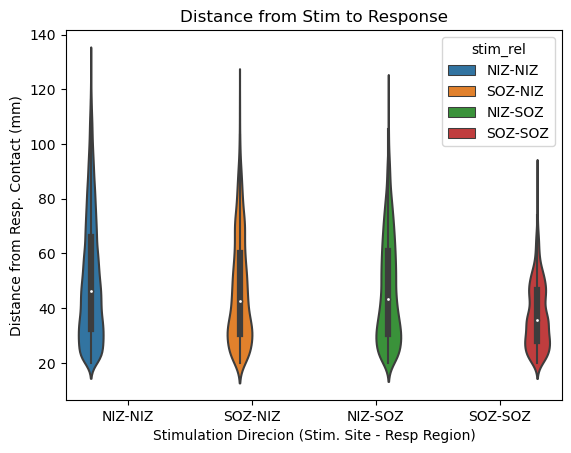

In [25]:
cols = ['NIZ-NIZ', 'SOZ-SOZ','SOZ-NIZ', 'NIZ-SOZ']

sns.violinplot(ev_dist_df[ev_dist_df.stim_rel.isin(cols)],y='dist', x='stim_rel',hue='stim_rel')
plt.ylabel("Distance from Resp. Contact (mm)")
plt.xlabel("Stimulation Direcion (Stim. Site - Resp Region)")
plt.title("Distance from Stim to Response")
plt.savefig("../viz/stim_dists.pdf", transparent=True)
#TODO ttest distances to make sure they're not super diff
a = ev_dist_df[ev_dist_df.stim_rel =='NIZ-NIZ'].dist
b = ev_dist_df[ev_dist_df.stim_rel == 'NIZ-SOZ'].dist
c = ev_dist_df[ev_dist_df.stim_rel == 'SOZ-NIZ'].dist
d = ev_dist_df[ev_dist_df.stim_rel == 'SOZ-SOZ'].dist
F, p  = f_oneway(a, b, c, d)
print(f"F values for distances between stim contact and response contact:{F}\n p-values:{p}")

#### Compariing distance between stim region and response region. 
It seems like the average distance is quite different between the various stim relations

In [26]:

mTLE_df = ev_dist_df[ev_dist_df.subj.isin(TLE_IDS)]
print(f"shape of TLE df {mTLE_df.shape}")
nonfocal_df = ev_dist_df[ev_dist_df.subj.isin(NON_TLE_IDS)]
print(f"shape of non TLE df {nonfocal_df.shape}")

shape of TLE df (17107, 5)
shape of non TLE df (24459, 5)


TtestResult(statistic=34.4890798634, pvalue=5.0243904885841926e-257, df=41564.0)


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

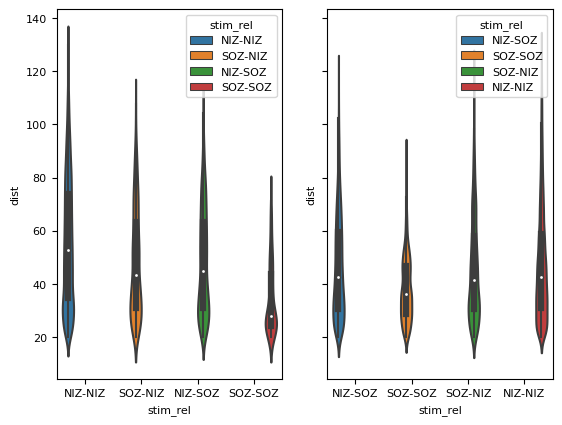

In [27]:
plt.rcParams.update({'font.size': 8})

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)
ax = sns.violinplot(mTLE_df, x='stim_rel', y='dist',hue='stim_rel',ax=ax1,legend=False)
ax = sns.violinplot(nonfocal_df, x='stim_rel', y='dist',hue='stim_rel',ax=ax2, legend=False)
tle_alpha = mTLE_df.dist
non_alpha = nonfocal_df.dist

print(ttest_ind(tle_alpha, non_alpha))

In [28]:
def bin_distances(dist, binsize=2):
    return dist//binsize
ev_dist_df['dist_bin'] = ev_dist_df.dist.apply(bin_distances)*2


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

At 128.0 dist ANOVA returns F_onewayResult(statistic=nan, pvalue=nan)
At 20.0 dist ANOVA returns F_onewayResult(statistic=8.662304374255694, pvalue=1.0394554487101722e-05)
At 22.0 dist ANOVA returns F_onewayResult(statistic=9.08428488371683, pvalue=5.830823044543537e-06)
At 24.0 dist ANOVA returns F_onewayResult(statistic=10.38284989577467, pvalue=8.884571333914719e-07)
At 26.0 dist ANOVA returns F_onewayResult(statistic=3.007880443303982, pvalue=0.02923733644963955)
At 28.0 dist ANOVA returns F_onewayResult(statistic=6.798432556438576, pvalue=0.00014747307397283672)
At 30.0 dist ANOVA returns F_onewayResult(statistic=2.07721455795214, pvalue=0.10122901667215585)
At 32.0 dist ANOVA returns F_onewayResult(statistic=0.5184747023371881, pvalue=0.6695953991155381)
At 34.0 dist ANOVA returns F_onewayResult(statistic=1.297241707516506, pvalue=0.2737305482302962)
At 36.0 dist ANOVA returns F_onewayResult(statistic=1.440562842404488, pvalue=0.2291919959674452)
At 38.0 dist ANOVA returns F_onew

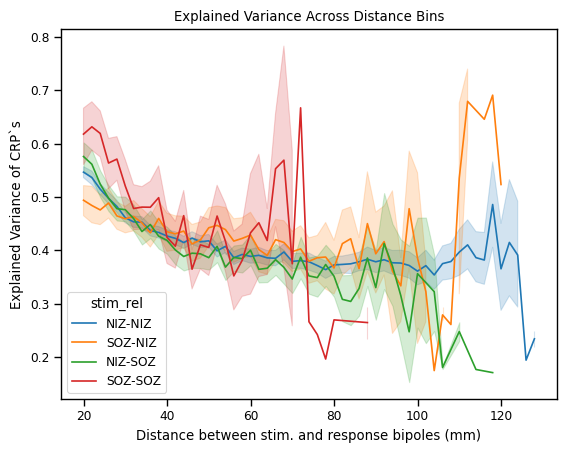

In [29]:
with sns.plotting_context("paper"):
    ax = sns.lineplot(ev_dist_df, x="dist_bin", y='explained_variance', hue='stim_rel')
    plt.xlabel("Distance between stim. and response bipoles (mm)")
    plt.ylabel("Explained Variance of CRP`s")
for bin in set(ev_dist_df.dist_bin):
    df = ev_dist_df[ev_dist_df.dist_bin == bin]
    a = df[df.stim_rel == "SOZ-SOZ"].explained_variance
    b = df[df.stim_rel == "SOZ-NIZ"].explained_variance
    c = df[df.stim_rel == "NIZ-SOZ"].explained_variance
    d = df[df.stim_rel == "NIZ-NIZ"].explained_variance
    print(f"At {bin} dist ANOVA returns {f_oneway(a, b, c,d)}")
    plt.title("Explained Variance Across Distance Bins")
#TODO - anova each bin

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

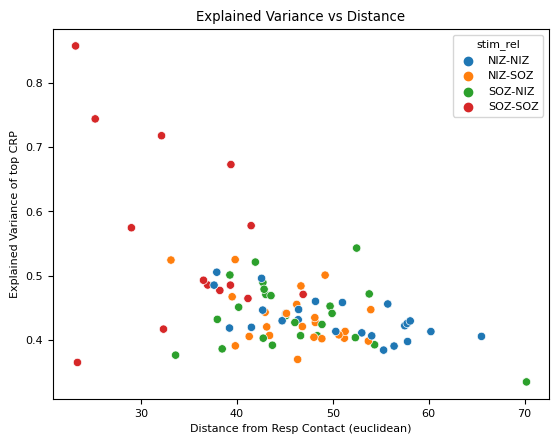

In [30]:
plot_df = ev_dist_df[['subj','stim_rel','dist','explained_variance']].groupby(['subj','stim_rel']).mean().reset_index()
# plot_df = ev_dist_df
cols = ['NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']
sns.scatterplot(data=plot_df[plot_df.stim_rel.isin(cols)], x='dist', y='explained_variance', hue='stim_rel')
plt.title("Explained Variance vs Distance")
plt.xlabel("Distance from Resp Contact (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_by_stim_rel.pdf",transparent=True)

In [31]:
# sns.lineplot(data=zgroup_df, x='dist', y='explained_variance', hue='stim_rel')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

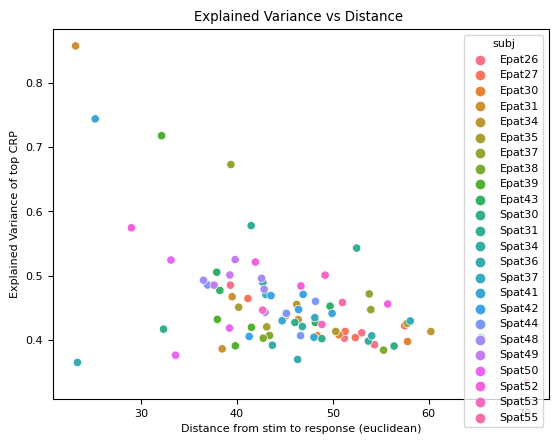

In [32]:

sns.scatterplot(data=zgroup_df, x='dist', y='explained_variance', hue='subj')
plt.title("Explained Variance vs Distance ")
plt.xlabel("Distance from stim to response (euclidean)")
plt.ylabel("Explained Variance of top CRP")
plt.savefig(f"../viz/ev_dist_from_stim.pdf",transparent=True)

In [33]:

from scipy.stats import ttest_1samp

In [34]:
plt.rcParams.update({'font.size': 16})


### Alpha Prime 
Testing Average Deflection - should represent strength of canonical response    

In [35]:
tst_df = z_dfs

In [36]:
# sns.histplot(data=tst_df,hue='stim_rel', x='alpha_z')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Result of omnnibus test, ANOCA: F_onewayResult(statistic=1.5686554825194197, pvalue=0.194654522551132)


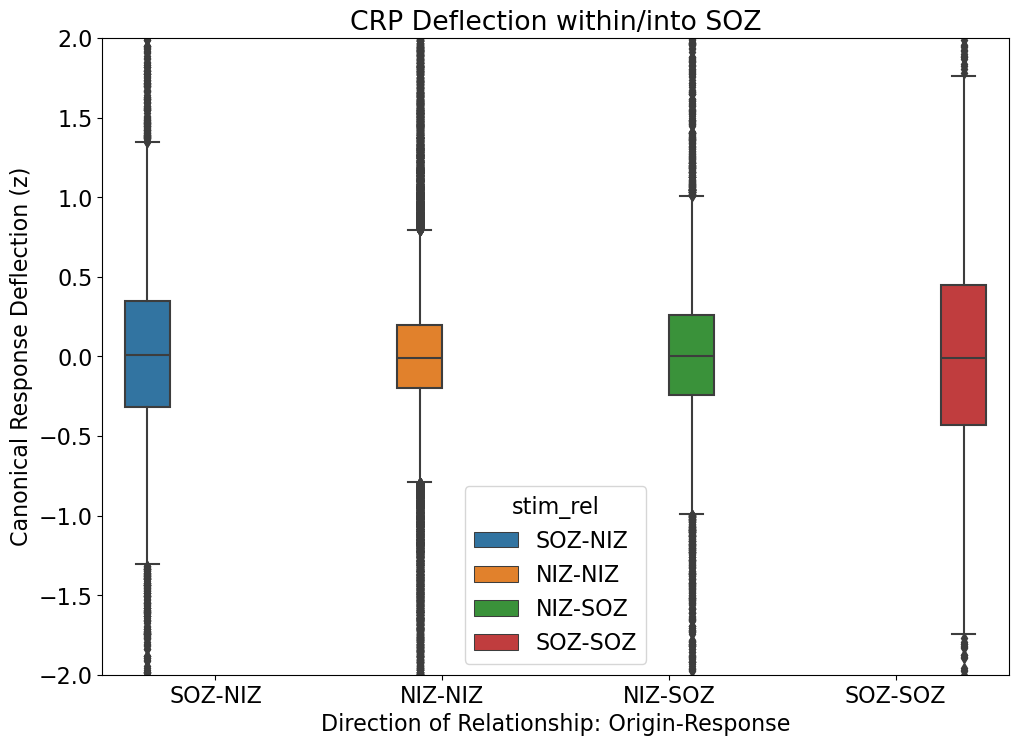

In [37]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
cols = [ 'NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']

ax = sns.boxplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].alpha_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].alpha_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].alpha_z
d =  tst_df[tst_df.stim_rel == 'NIZ-NIZ'].alpha_z

# print(f"SOZ-SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

# print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
# print(f"Comparing NIZ-NIZ  vs NIZ-SOZ: {ttest_ind(d,a)}")
# print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,a)}")
# print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,c)}")
# print(f"Comparing stimulation in SOZ to NIZ with into the SOZ from the NIZ: {ttest_ind(a,c)}")
print(f"Result of omnnibus test, ANOCA: {f_oneway(a,b,c,d)}")

plt.ylabel("Canonical Response Deflection (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Deflection within/into SOZ")
plt.ylim(-2,2 )
plt.savefig("../viz/relabel_boxplot_crp_alphaz_box.pdf", transparent=True)

#### Alpha Sub-Analysis mTLE group vs non
Do patients with mTLE have higher deflections within the SOZ?

In [38]:
mTLE_df = tst_df[tst_df.subj.isin(TLE_IDS)]
print(f"shape of TLE df {mTLE_df.shape}")
nonfocal_df = tst_df[tst_df.subj.isin(NON_TLE_IDS)]
print(f"shape of non TLE df {nonfocal_df.shape}")

shape of TLE df (17107, 12)
shape of non TLE df (24459, 12)


In [39]:
mTLE_df

,subj,stim_sesh,stim_rel,alpha_prime,TR,explained_variance,t_peak_0,dist,alpha_z,TR_z,ev_z,peak_t_z
5171,Epat31,AC1-AC2-AC7-AC8,NIZ-NIZ,-3.380694,0.089844,0.560272,0.003906,20.9440,-0.949804,-1.272761,0.648980,-0.759965
5172,Epat31,AC1-AC2-AC8-AC9,NIZ-NIZ,-3.215479,0.109375,0.468038,0.007812,24.5139,-0.903291,-1.194219,0.184445,-0.488998
5173,Epat31,AC1-AC2-AC9-AC10,NIZ-NIZ,7.673245,0.093750,0.418081,0.017578,28.1253,2.162194,-1.257052,-0.067166,0.188419
5174,Epat31,AC1-AC2-AH1-AH2,NIZ-NIZ,2.596290,0.289062,0.401559,0.005859,58.0749,0.732887,-0.471638,-0.150376,-0.624482
5175,Epat31,AC1-AC2-AH10-AH11,NIZ-NIZ,-2.062019,0.359375,0.346022,0.009766,62.9683,-0.578559,-0.188888,-0.430090,-0.353515
...,...,...,...,...,...,...,...,...,...,...,...,...
9442,Epat35,RTP8-RTP9-RIT9-RIT10,NIZ-NIZ,1.022127,0.148438,0.260966,0.005859,45.1460,0.273038,-0.677789,-0.801823,-0.585356
9443,Epat35,RTP8-RTP9-RP1-RP2,SOZ-NIZ,1.115017,0.796875,0.171780,0.044922,32.5011,0.299866,1.726284,-1.271722,1.619434
9444,Epat35,RTP8-RTP9-RP9-RP10,NIZ-NIZ,-3.600833,0.195312,0.404243,0.011719,33.0168,-1.062144,-0.504001,-0.046938,-0.254638
9445,Epat35,RTP8-RTP9-RSMG4-RSMG5,NIZ-NIZ,0.151631,0.843750,0.179855,0.011719,67.3761,0.021625,1.900072,-1.229177,-0.254638


TtestResult(statistic=2.321143540930798, pvalue=0.020439541238476903, df=1248.0)


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

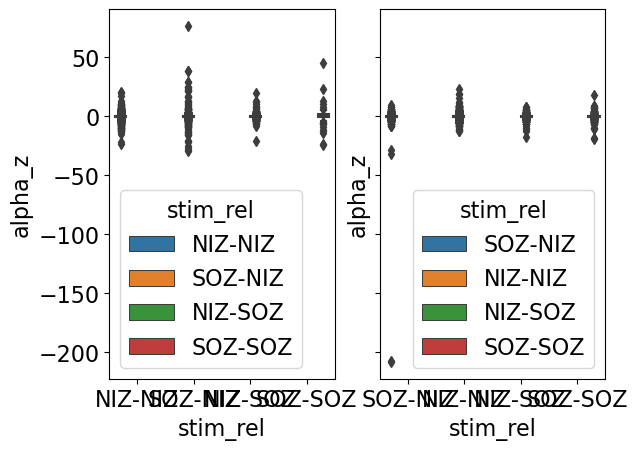

In [40]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)
ax = sns.boxplot(mTLE_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax1)
ax = sns.boxplot(nonfocal_df, x='stim_rel', y='alpha_z',hue='stim_rel',ax=ax2)
tle_alpha = mTLE_df[mTLE_df.stim_rel =='SOZ-SOZ'].alpha_z
non_alpha = nonfocal_df[nonfocal_df.stim_rel =='SOZ-SOZ'].alpha_z

print(ttest_ind(tle_alpha, non_alpha))

## Response Peak Timing

In [49]:
tst_df = zgroup_df

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Comparing NIZ-NIZ  vs NIZ-SOZ: TtestResult(statistic=3.3459220590888883, pvalue=0.0016625269606286256, df=45.0)
Comparing SOZ-SOZ to NIZ-SOZ: TtestResult(statistic=0.17665288111818273, pvalue=0.8607993161397306, df=35.0)
Comparing SOZ-SOZ to NIZ-SOZ: TtestResult(statistic=-1.6733356320732085, pvalue=0.10293040652651085, df=36.0)
Comparing stimulation in SOZ to NIZ with into the SOZ from the NIZ: TtestResult(statistic=-2.752493823904627, pvalue=0.008496520731666958, df=45.0)
Result of omnnibus test, ANOVA: F_onewayResult(statistic=3.443959674826942, pvalue=0.02050156502708151)


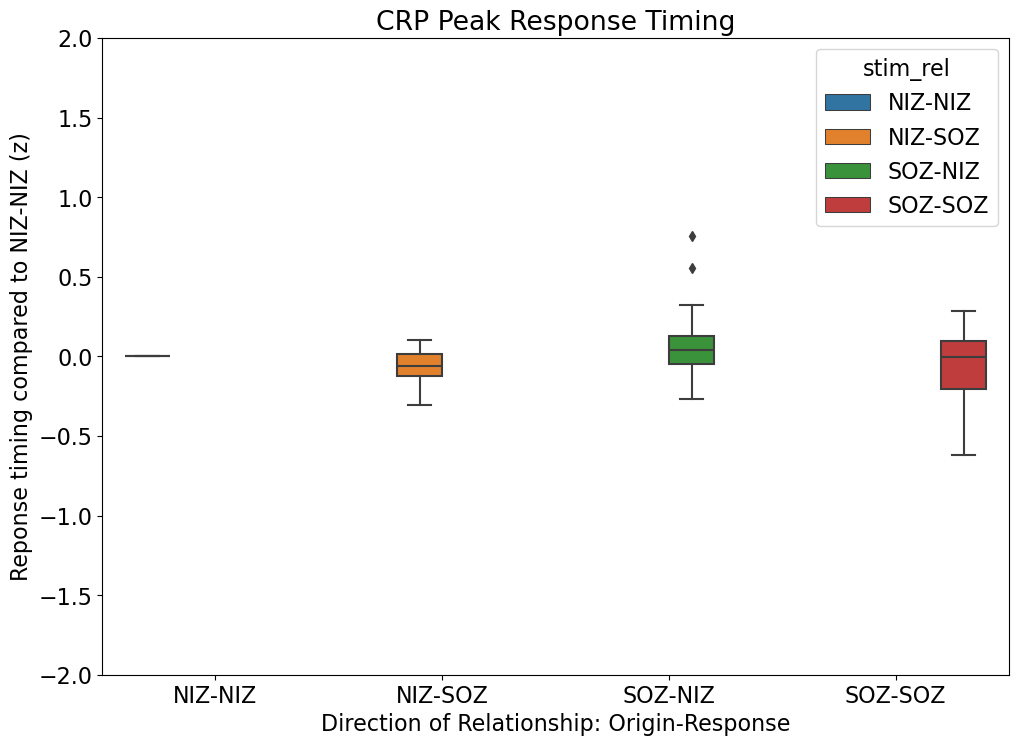

In [50]:

fig, ax = plt.subplots(figsize=[11.7,8.27])
cols = [ 'NIZ-NIZ', 'NIZ-SOZ', 'SOZ-SOZ', 'SOZ-NIZ']

ax = sns.boxplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='peak_t_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].peak_t_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].peak_t_z
c = tst_df[tst_df.stim_rel == 'SOZ-NIZ'].peak_t_z
d =  tst_df[tst_df.stim_rel == 'NIZ-NIZ'].peak_t_z

# print(f"SOZ-SOZ mean : {np.mean(b)} vs NIZ->SOZ mean {np.mean(a)}")

# print(f"SOZ->NIZ: {np.mean(c)} vs NIZ->SOZ mean {np.mean(a)}")
print(f"Comparing NIZ-NIZ  vs NIZ-SOZ: {ttest_ind(d,a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,a)}")
print(f"Comparing SOZ-SOZ to NIZ-SOZ: {ttest_ind(b,c)}")
print(f"Comparing stimulation in SOZ to NIZ with into the SOZ from the NIZ: {ttest_ind(a,c)}")
print(f"Result of omnnibus test, ANOVA: {f_oneway(a,b,c,d)}")

plt.ylabel("Reponse timing compared to NIZ-NIZ (z)")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.title("CRP Peak Response Timing")
plt.ylim(-2,2 )
plt.savefig("../viz/relabel_boxplot_crp_peak_timing_box.pdf", transparent=True)

### Tr_z Response Duration
Note: this is not the same as examining delay -> this would require a bit more investigation into onset times

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

NIZ-SOZ zscore 0.06666616877912951
SOZ-SOZ zscore 0.02674832218358211
TtestResult(statistic=1.2968165903879798, pvalue=0.19473876642912857, df=6729.0)


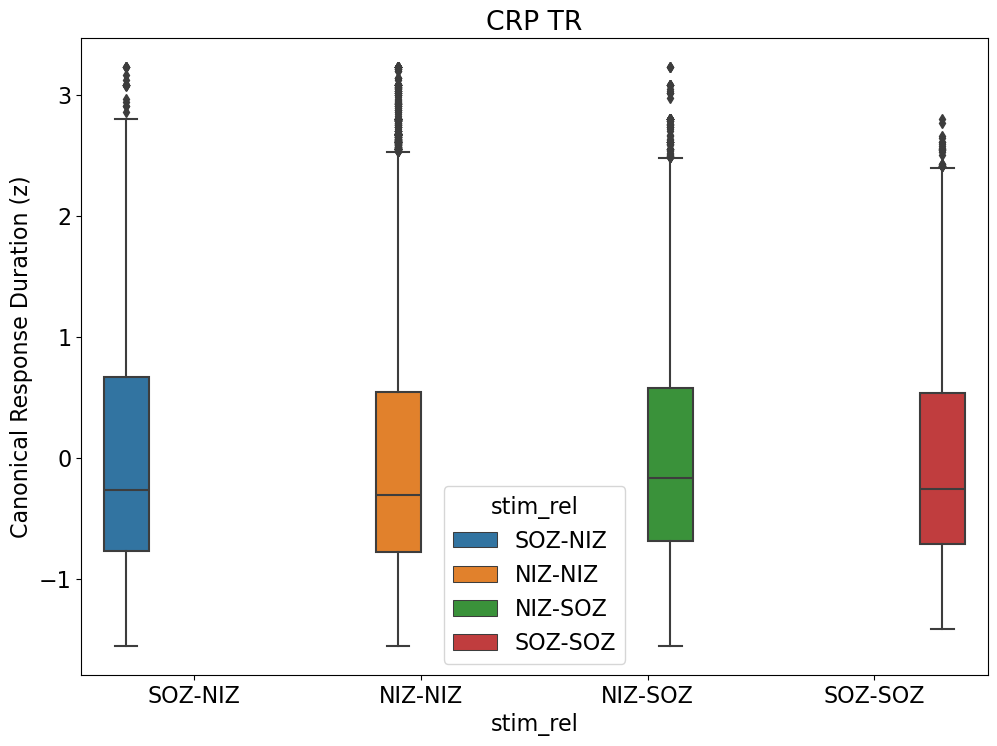

In [43]:
fig, ax = plt.subplots(figsize=[11.7,8.27])
tst_df = z_dfs

ax = sns.boxplot(tst_df, x='stim_rel', y='TR_z',hue='stim_rel',ax=ax)
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].TR_z
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].TR_z
c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].TR_z
d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].TR_z

# b= ttest_1samp(b,0)
# print(b)
print(f"NIZ-SOZ zscore {np.mean(a)}")
print(f"SOZ-SOZ zscore {np.mean(b)}")
print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )


plt.ylabel("Canonical Response Duration (z)")
plt.title("CRP TR")
plt.savefig("../viz/relabel_crp_TRz.pdf",transparent=True)

### Explained Variance

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Result of omnbius, ANOVA: F_onewayResult(statistic=12.549936045895759, pvalue=8.08353643146537e-07)
TtestResult(statistic=-3.934837965734164, pvalue=0.00037680783588428166, df=35.0)


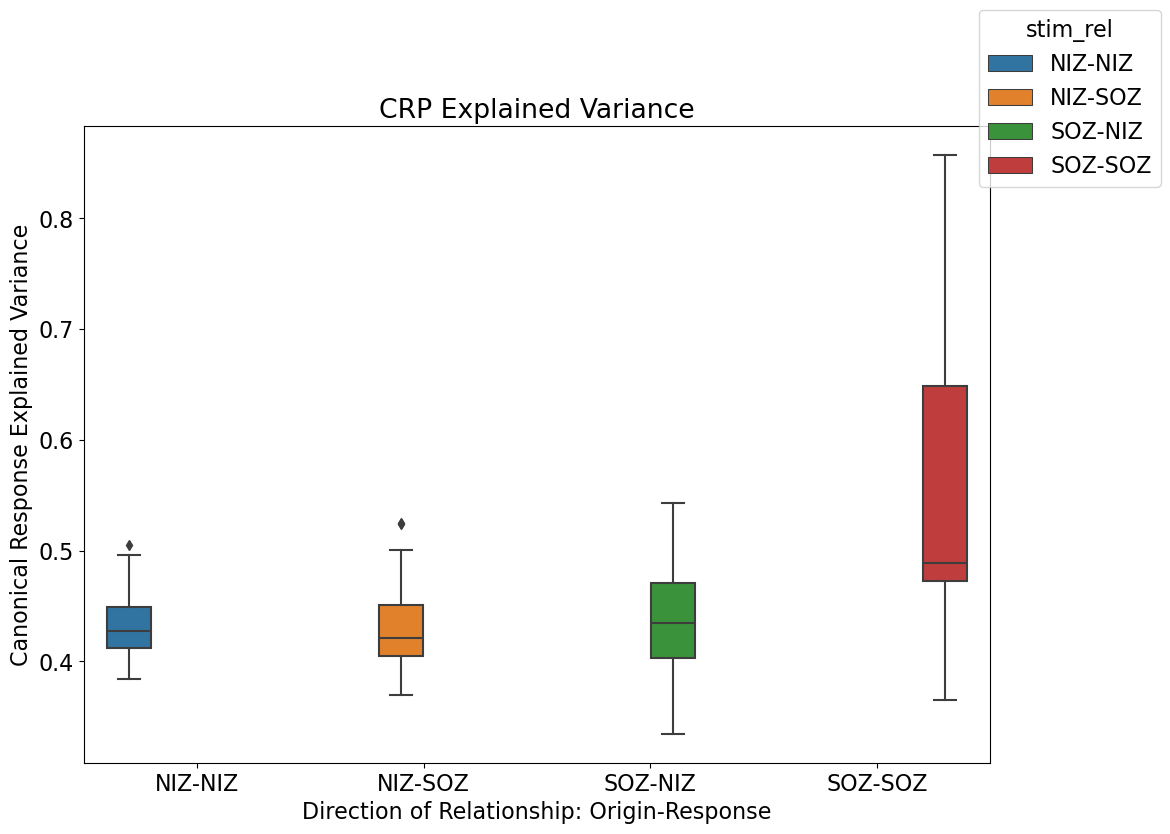

In [52]:

fig, ax = plt.subplots(figsize=[11.7,8.27])


ax = sns.boxplot(tst_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2,1.2))
a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
c = tst_df[tst_df.stim_rel == 'NIZ-NIZ'].explained_variance
d =  tst_df[tst_df.stim_rel == 'SOZ-NIZ'].explained_variance
print(f"Result of omnbius, ANOVA: {f_oneway(a,b,c,d)}")


print(ttest_ind(a,b))
# print(ttest_1samp(c,0))
# print(ttest_1samp(d,0) )

#TODO OMNIBUS test
plt.ylabel("Canonical Response Explained Variance")
plt.title("CRP Explained Variance")
plt.xlabel("Direction of Relationship: Origin-Response")
plt.savefig("../viz/relabel_CRP_ev_box.pdf", transparent=True, bbox_inches='tight')

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

0.5454936508275412
TtestResult(statistic=-3.7318213272406684, pvalue=0.0006541276782689715, df=36.0)


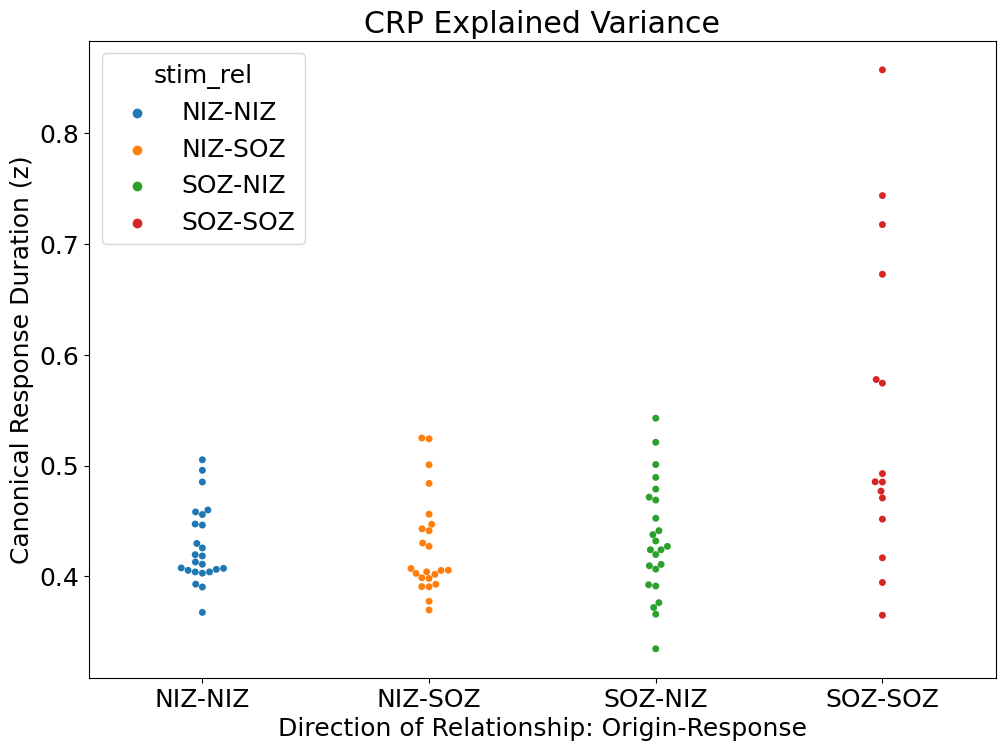

In [61]:
# fig, ax = plt.subplots(figsize=[11.7,8.27])


# ax = sns.swarmplot(tst_df[tst_df.stim_rel.isin(cols)], x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax)
# a = tst_df[tst_df.stim_rel=='NIZ-SOZ'].explained_variance
# b = tst_df[tst_df.stim_rel =='SOZ-SOZ'].explained_variance
# c = tst_df[tst_df.stim_rel == 'PZ-SOZ'].explained_variance
# d =  tst_df[tst_df.stim_rel == 'PZ-PZ'].explained_variance

# # b= ttest_1samp(b,0)
# print(np.mean(b))
# print(ttest_ind(a,b))
# # print(ttest_1samp(c,0))
# # print(ttest_1samp(d,0) )
# #TODO sample 4


# plt.ylabel("Canonical Response Duration (z)")
# plt.title("CRP Explained Variance")
# plt.xlabel("Direction of Relationship: Origin-Response")

# plt.savefig("../viz/relabel_CRP_ev_swarm.pdf", transparent=True)

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

TtestResult(statistic=2.8844287382140266, pvalue=0.012784302202213105, df=13.0)


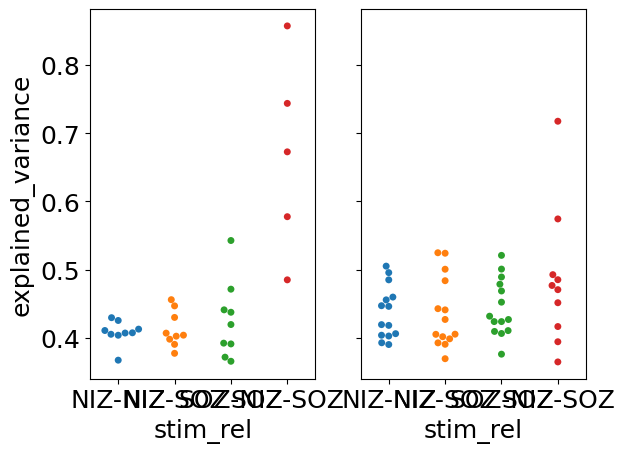

In [65]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2,sharey=True)

plt.rcParams.update({'font.size': 8})
ax = sns.boxplot(mTLE_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax1, legend=False)
ax = sns.boxplot(nonfocal_df, x='stim_rel', y='explained_variance',hue='stim_rel',ax=ax2, legend=False)
tle_alpha = mTLE_df[mTLE_df.stim_rel =='SOZ-SOZ'].explained_variance
non_alpha = nonfocal_df[nonfocal_df.stim_rel =='SOZ-SOZ'].explained_variance

print(ttest_ind(tle_alpha, non_alpha))

----

In [ ]:
# sns.histplot(data=group_df, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime Across all locations")

In [ ]:
# tst = group_df.reset_index()
# tst = tst[tst.resp_reg_label =='SOZ']
# sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime in SOZ locations")

In [ ]:
# tst = group_df.reset_index()
# tst = tst[tst.resp_reg_label =='PZ']
# sns.histplot(data=tst, x= 'alpha_prime', hue='stim_reg_label',multiple='stack',log_scale=True)
# plt.title("Alpha prime in PZ locations")


In [ ]:
# sns.violinplot(plot_df[plot_df.subj==plot_df.subj.values[0]],x='resp_reg_label', y='alpha_prime', hue='stim_reg_label', log_scale=True)
